In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-06-22 16:31:57 - ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-06-22 16:31:57 - src.ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-06-22 16:31:57 - wandb.docker.auth - DEBUG    - Trying paths: ['/Users/guydavidson/.docker/config.json', '/Users/guydavidson/.dockercfg']
2023-06-22 16:31:57 - wandb.docker.auth - DEBUG    - Found file at path: /Users/guydavidson/.docker/config.json
2023-06-22 16:31:57 - wandb.docker.auth - DEBUG    - Found 'credsStore' section


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,0,...,0.980519,0.981795,0.972647,0.982941,0.983447,0.985028,0.922134,0.917226,0.975440,0.987710
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,0,...,0.982845,0.983494,0.969335,0.980352,0.979375,0.985628,0.924614,0.933171,0.947230,0.963873
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,1,...,0.977261,0.981289,0.000000,0.000000,0.000000,0.000000,0.848037,0.861549,0.925661,0.945054
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,1,...,0.987944,0.987532,0.000000,0.000000,0.000000,0.000000,0.922134,0.917226,0.975440,0.987710
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0,...,0.983483,0.981809,0.000000,0.000000,0.000000,0.000000,0.979648,0.978512,0.971713,0.987759


In [5]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [6]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        if isinstance(key, int):
            key_bits = count_set_bits(key)
        else:
            key_bits = sum(k != 0 for k in key)

        results_by_feature_count[key_bits].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [7]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']

def plot_sampler_fitness_trajectory(
        evo: PopulationBasedSampler, title: typing.Optional[str] = None, 
        axsize: typing.Tuple[int, int] = (8, 6),
        plot_metrics: typing.Optional[bool] = None, 
        ignore_metrics: typing.Optional[typing.List[str]] = DEFAULT_IGNORE_METRICS,
        subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
        min_real_game_fitness: float = 57.9193, max_real_game_fitness: float = 62.9249): 

    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0  # type: ignore

    if ignore_metrics is None:
        ignore_metrics = []
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys() if key not in ignore_metrics}  # type: ignore
        for step_dict in evo.archive_metrics_history:  # type: ignore
            for key, value in step_dict.items():
                if key in metrics:
                    metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

In [8]:
# fitness_rank_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, Fitness Rank')

# fitness_rank_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, Fitness Rank')

# ucb_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, UCB')

# ucb_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, UCB')


In [9]:
# fitness_rank_object_categories = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank')

# fitness_rank_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank')

# fitness_rank_object_categories_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories_crossover, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank, With Crossover')

# fitness_rank_predicates_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates_crossover, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, With Crossover')

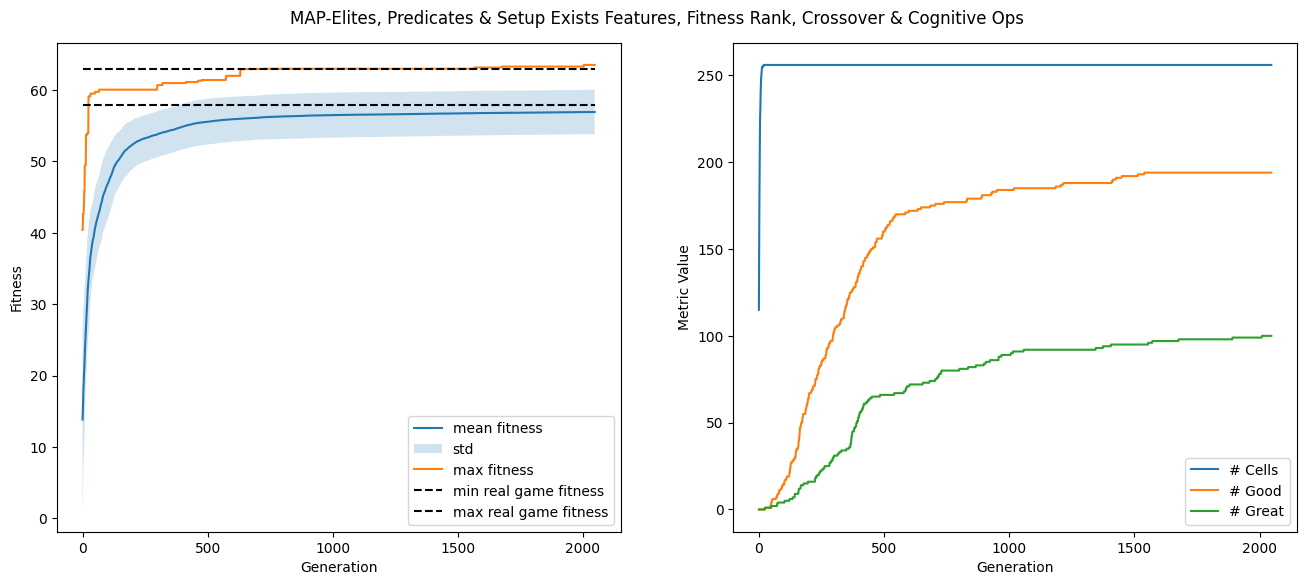

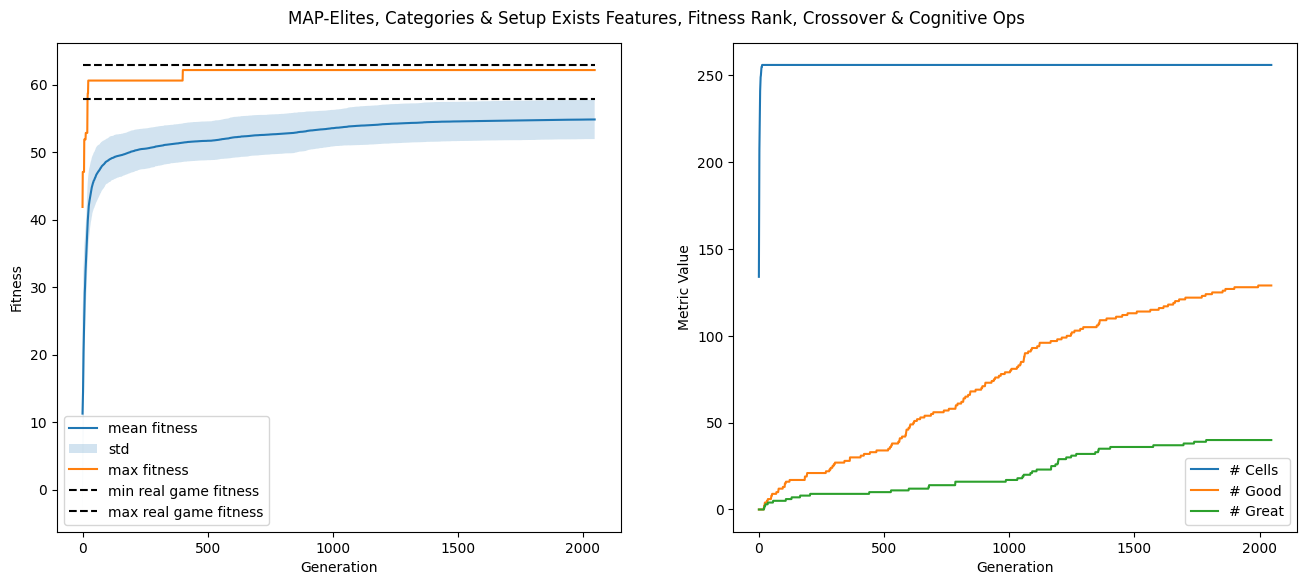

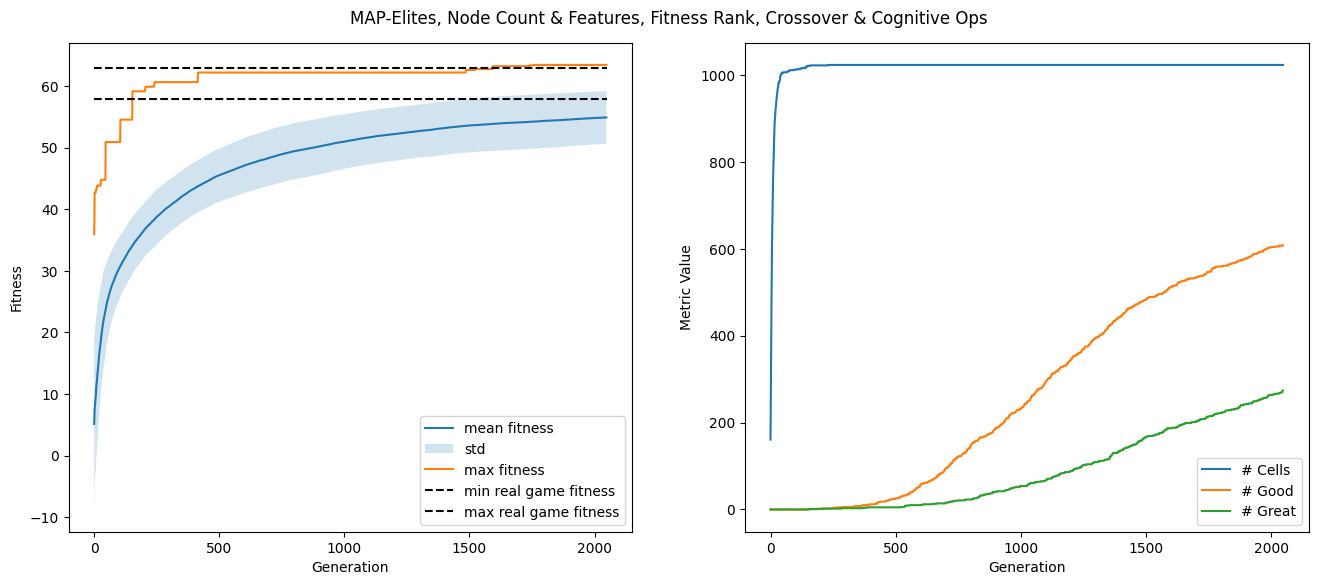

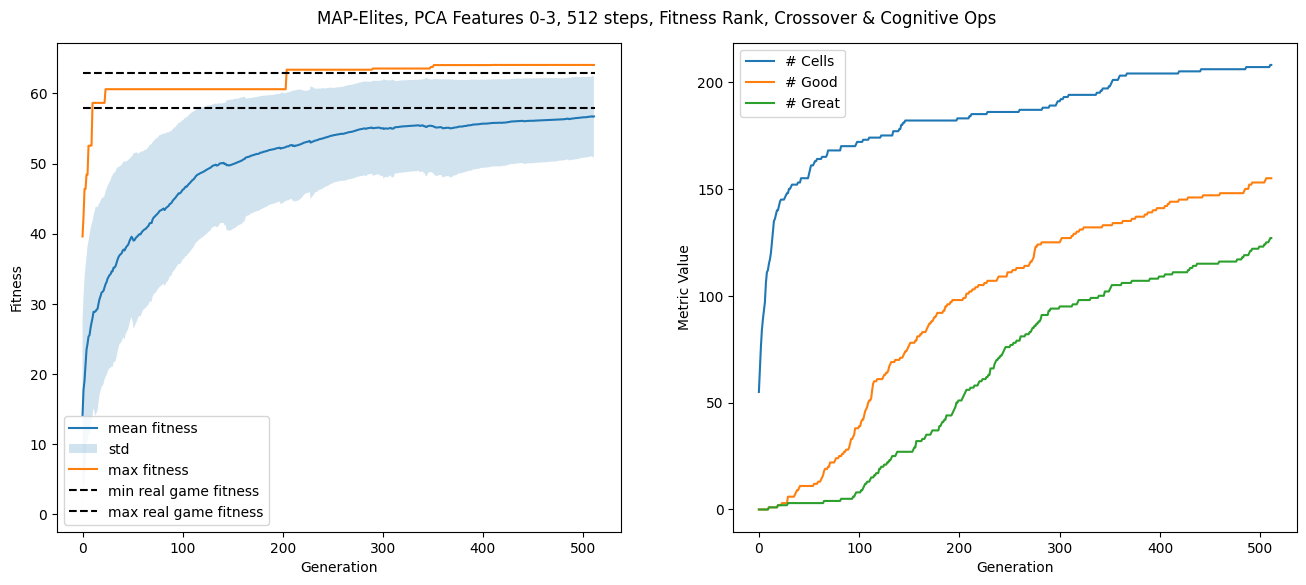

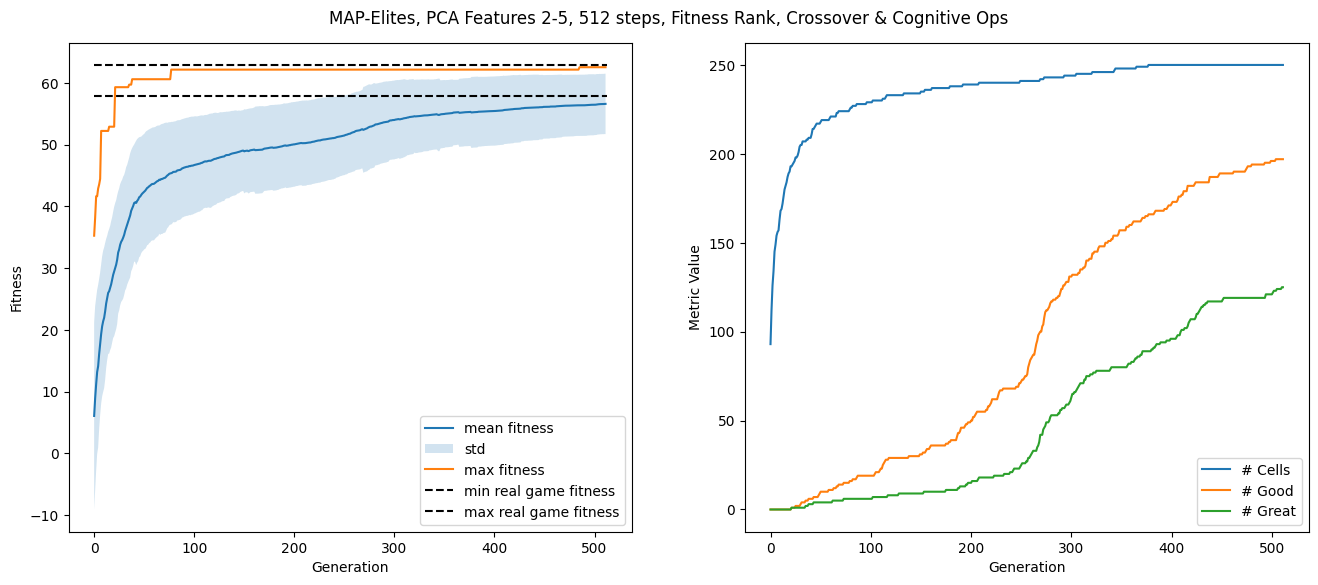

In [10]:
specific_predicates_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_specific_predicates_setup_final'))
plot_sampler_fitness_trajectory(specific_predicates_setup, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

specific_categories_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_specific_categories_setup_final'))
plot_sampler_fitness_trajectory(specific_categories_setup, 'MAP-Elites, Categories & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_node_count_specific_predicates_final'))
plot_sampler_fitness_trajectory(node_count_predicates, 'MAP-Elites, Node Count & Features, Fitness Rank, Crossover & Cognitive Ops')

pca_features_0_3 = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19', 'samples', 'map_elites_fitness_rank_pca_features_0-3_gen_512'))
plot_sampler_fitness_trajectory(pca_features_0_3, 'MAP-Elites, PCA Features 0-3, 512 steps, Fitness Rank, Crossover & Cognitive Ops')

pca_features_2_5 = typing.cast(MAPElitesSampler, utils.load_data('2023_06_20', 'samples', 'map_elites_fitness_rank_pca_features_2-5_gen_512'))
plot_sampler_fitness_trajectory(pca_features_2_5, 'MAP-Elites, PCA Features 2-5, 512 steps, Fitness Rank, Crossover & Cognitive Ops')

In [18]:
model = node_count_predicates
index = 2
key = model.top_sample_key(index)
sample = model.population[key]  # type: ignore


# print(ast_str)
# grammar_parser.parse(ast_str)

game_fitness, game_features = model._score_proposal(sample, return_features=True)
print(game_fitness)

sample_copy = deepcopy_ast(sample)
sample_copy = list(sample_copy)
for i in range(len(sample_copy)):
    if isinstance(sample_copy[i], tuple) and sample_copy[i][0] in (ast_parser.SETUP, ast_parser.TERMINAL) and len(sample_copy[i]) < 3:
        sample_copy[i] = (*sample_copy[i], ')')
sample_copy = tuple(sample_copy)

copied_fitness, copied_features = model._score_proposal(sample_copy, return_features=True)
print(copied_fitness)

sample_copy_str = ast_printer.ast_to_string(sample_copy, '\n')
reparsed_sample = grammar_parser.parse(sample_copy_str)
reparsed_fitness, reparsed_features = model._score_proposal(reparsed_sample, return_features=True)
print(reparsed_fitness)

# {key: value for key, value in sample_features.items() if 'once' in key}
for key in game_features:
    if game_features[key] != reparsed_features[key]:
        print(key, game_features[key], reparsed_features[key])


63.1048698425293
63.1048698425293
63.1048698425293


In [14]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = node_count_predicates
index = 2
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on, 
    postprocess_sample=True, features=key_features)
sample = model.population[key] 
print_nearest_real_games(sample, n_similar_real_games_to_print)

Sample features for key (7, 0, 1, 0, 1, 1, 1, 1):
node_count: 7
predicate_used_adjacent: 0
predicate_used_agent_holds: 1
predicate_used_between: 0
predicate_used_in: 1
predicate_used_in_motion: 1
predicate_used_on: 1
predicate_used_touch: 1


### Energy of visualized game: -63.105

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                             | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------|----------------------------------------------------------------------------------|
| length_of_then_modals_3: **1.244** = (1.000) * 1.244                 | ast_ngram_full_n_7_score: **-17.859** = (0.866) * -20.622                        |
| agent_holds_arg_types_balls_constraints: **1.118** = (1.000) * 1.118 | ast_ngram_constraints_n_7_score: **-13.824** = (0.902) * -15.320                 |
| mean_depth_constraints_1: **0.998** = (1.000) * 0.998                | ast_ngram_setup_n_5_score: **-6.673** = (0.962) * -6.935                         |
| starts_and_ends_once: **0.665** = (0.909) * 0.732                    | all_variables_used: **-4.577** = (1.000) * -4.577                                |
| max_quantification_count_setup_1: **0.640** = (1.000) * 0.640        | ast_ngram_scoring_n_5_score: **-3.261** = (0.988) * -3.301                       |
| node_count_terminal_1: **0.608** = (1.000) * 0.608                   | ast_ngram_terminal_n_5_score: **-2.203** = (0.973) * -2.263                      |
| node_count_setup_2: **0.581** = (1.000) * 0.581                      | on_arg_types_furniture_any_object_constraints: **-1.731** = (1.000) * -1.731     |
| max_width_setup_2: **0.423** = (1.000) * 0.423                       | all_variables_defined: **-1.619** = (1.000) * -1.619                             |
| no_adjacent_same_modal: **0.332** = (-1.000) * -0.332                | max_width_scoring_0: **-1.403** = (1.000) * -1.403                               |
| in_motion_arg_types_balls_constraints: **0.319** = (1.000) * 0.319   | in_arg_types_receptacles_any_object_constraints: **-1.200** = (1.000) * -1.200   |
| max_depth_scoring_0: **0.308** = (1.000) * 0.308                     | setup_objects_used: **-1.149** = (1.000) * -1.149                                |
| predicate_under_modal_once_on: **0.303** = (1.000) * 0.303           | setup_quantified_objects_used: **-1.132** = (1.000) * -1.132                     |
| mean_depth_scoring_0: **0.256** = (1.000) * 0.256                    | predicate_under_modal_hold_agent_holds: **-1.075** = (1.000) * -1.075            |
| node_count_scoring_0: **0.253** = (1.000) * 0.253                    | predicate_under_modal_once_agent_holds: **-1.068** = (1.000) * -1.068            |
| predicate_under_modal_once_in_motion: **0.164** = (1.000) * 0.164    | in_arg_types_receptacles_balls_constraints: **-0.945** = (1.000) * -0.945        |
| predicate_under_modal_hold_touch: **0.031** = (1.000) * 0.031        | touch_arg_types_agent_balls_constraints: **-0.928** = (1.000) * -0.928           |
| max_depth_terminal_2: **0.018** = (1.000) * 0.018                    | touch_arg_types_agent_receptacles_constraints: **-0.876** = (1.000) * -0.876     |
| num_preferences_defined_6: **0.003** = (1.000) * 0.003               | compositionality_structure_0: **-0.768** = (1.000) * -0.768                      |
|                                                                      | max_width_terminal_0: **-0.725** = (1.000) * -0.725                              |
|                                                                      | max_number_variables_types_quantified_variables_1: **-0.648** = (1.000) * -0.648 |

### Game:

```pddl
(define (game evo-1970-194-1) (:domain few-objects-room-v1)
(:setup
  (and
    (exists (?v0 - hexagonal_bin)
      (game-conserved
        (and
          (on bed ?v0)
          (object_orientation ?v0 upright)
        )
      )
    )
  )
(:constraints
  (and
    (preference preference0
      (exists (?v1 - game_object ?v2 - hexagonal_bin)
        (at-end
          (and
            (touch agent ?v2)
            (on bed ?v1)
          )
        )
      )
    )
    (preference preference1
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference2
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference3
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference4
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference5
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference6
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference7
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference8
      (exists (?v3 - dodgeball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference9
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference10
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (and (on floor agent) (agent_holds ?v3) ) )
        )
      )
    )
    (preference preference11
      (exists (?v3 - dodgeball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (touch floor ?v3) ) )
          (hold (and (not (agent_holds ?v3) ) (touch agent ?v3) ) )
        )
      )
    )
    (preference preference12
      (exists (?v1 - (either dodgeball dodgeball) ?v4 - hexagonal_bin)
        (at-end
          (in ?v4 ?v1)
        )
      )
    )
    (preference preference13
      (exists (?v1 - game_object ?v4 - hexagonal_bin)
        (at-end
          (in ?v4 ?v1)
        )
      )
    )
  )
)
(:terminal
  (>= (total-time) 1 )
(:scoring
  (count preference0)
)
)
```

### Nearest real game #1:

Edit distance to sample 2053, real game nearest neighbor distances [1270, 1412, 1423]):


```pddl
(define (game 5f0a5a99dbbf721316f118e2-58) (:domain medium-objects-room-v1)
(:setup
  (and
    (exists (?b - building)
      (and
        (game-conserved
          (= (building_size ?b) 6)
        )
        (forall (?l - block)
          (or
            (game-conserved
              (and
                (in ?b ?l)
                (not
                  (exists (?l2 - block)
                    (and
                      (in ?b ?l2)
                      (not
                        (same_object ?l ?l2)
                      )
                      (same_type ?l ?l2)
                    )
                  )
                )
              )
            )
            (game-optional
              (not
                (exists (?s - shelf)
                  (on ?s ?l)
                )
              )
            )
          )
        )
      )
    )
  )
)
(:constraints
  (and
    (preference gameBlockFound
      (exists (?l - block)
        (then
          (once (game_start ) )
          (hold (not (exists (?b - building) (and (in ?b ?l) (is_setup_object ?b) ) ) ) )
          (once (agent_holds ?l) )
        )
      )
    )
    (preference towerFallsWhileBuilding
      (exists (?b - building ?l1 ?l2 - block)
        (then
          (once (and (in ?b ?l1) (agent_holds ?l2) (not (is_setup_object ?b) ) ) )
          (hold-while (and (not (agent_holds ?l1) ) (in ?b ?l1) (or (agent_holds ?l2) (in_motion ?l2) ) ) (touch ?l1 ?l2) )
          (hold (and (in_motion ?l1) (not (agent_holds ?l1) ) ) )
          (once (not (in_motion ?l1) ) )
        )
      )
    )
    (preference matchingBuildingBuilt
      (exists (?b1 ?b2 - building)
        (at-end
          (and
            (is_setup_object ?b1)
            (not
              (is_setup_object ?b2)
            )
            (forall (?l1 ?l2 - block)
              (or
                (not
                  (in ?b1 ?l1)
                )
                (not
                  (in ?b1 ?l2)
                )
                (not
                  (on ?l1 ?l2)
                )
                (exists (?l3 ?l4 - block)
                  (and
                    (in ?b2 ?l3)
                    (in ?b2 ?l4)
                    (on ?l3 ?l4)
                    (same_type ?l1 ?l3)
                    (same_type ?l2 ?l4)
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)
(:scoring
  (+ (* 5 (count-once-per-objects gameBlockFound) )
    (* 100 (count-once matchingBuildingBuilt) )
    (* (- 10 )
      (count towerFallsWhileBuilding)
    )
  )
)
)
```

### Nearest real game #2:

Edit distance to sample 2204, real game nearest neighbor distances [1097, 1099, 1110]):


```pddl
(define (game 56cb8858edf8da000b6df354-32) (:domain many-objects-room-v1)
(:setup
  (and
    (exists (?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - (either cube_block cylindrical_block pyramid_block))
      (game-optional
        (and
          (on desk ?b1)
          (on desk ?b2)
          (on desk ?b3)
          (on ?b1 ?b4)
          (on ?b2 ?b5)
          (on ?b4 ?b6)
        )
      )
    )
    (exists (?w1 ?w2 - wall ?h - hexagonal_bin)
      (game-conserved
        (and
          (adjacent ?h ?w1)
          (adjacent ?h ?w2)
        )
      )
    )
  )
)
(:constraints
  (and
    (forall (?b - (either dodgeball golfball))
      (and
        (preference ballThrownToBin
          (exists (?h - hexagonal_bin)
            (then
              (once (agent_holds ?b) )
              (hold (and (not (agent_holds ?b) ) (in_motion ?b) ) )
              (once (and (not (in_motion ?b) ) (in ?h ?b) ) )
            )
          )
        )
        (preference blockInTowerKnocked
          (exists (?bl - building ?c - (either cube_block cylindrical_block pyramid_block))
            (then
              (once (and (agent_holds ?b) (on desk ?bl) (in ?bl ?c) ) )
              (hold-while (and (not (agent_holds ?b) ) (in_motion ?b) (not (or (agent_holds ?c) (touch agent ?c) ) ) ) (in_motion ?c) )
              (once (not (in_motion ?c) ) )
            )
          )
        )
        (preference throwAttempt
          (then
            (once (agent_holds ?b) )
            (hold (and (not (agent_holds ?b) ) (in_motion ?b) ) )
            (once (not (in_motion ?b) ) )
          )
        )
        (preference ballNeverThrown
          (then
            (once (game_start ) )
            (hold (not (agent_holds ?b) ) )
            (once (game_over ) )
          )
        )
      )
    )
  )
)
(:terminal
  (or
    (> (external-forall-maximize (count throwAttempt) ) 2 )
    (>= (count throwAttempt) 12 )
  )
)
(:scoring
  (* (>= (+ (count ballThrownToBin:dodgeball) (* 2 (count ballThrownToBin:golfball) )
      )
      2
    )
    (+ (count-once-per-objects blockInTowerKnocked) (count-once-per-objects ballNeverThrown:golfball) (* 2 (count-once-per-objects ballNeverThrown:dodgeball) )
    )
  )
)
)
```

### Nearest real game #3:

Edit distance to sample 2206, real game nearest neighbor distances [1781, 1834, 1951]):


```pddl
(define (game 5ea3a20ac30a773368592f9e-80) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference pinkObjectMovedToRoomCenter
      (exists (?o - game_object)
        (then
          (once (and (agent_holds ?o) (same_color ?o pink) ) )
          (hold (and (in_motion ?o) (not (agent_holds ?o) ) ) )
          (once (and (not (in_motion ?o) ) (< (distance room_center ?o) 1) ) )
        )
      )
    )
    (preference blueObjectMovedToRoomCenter
      (exists (?o - game_object)
        (then
          (once (and (agent_holds ?o) (same_color ?o blue) ) )
          (hold (and (in_motion ?o) (not (agent_holds ?o) ) ) )
          (once (and (not (in_motion ?o) ) (< (distance room_center ?o) 1) (exists (?o1 - game_object) (and (same_color ?o1 pink) (< (distance room_center ?o1) 1) ) ) ) )
        )
      )
    )
    (preference brownObjectMovedToRoomCenter
      (exists (?o - game_object)
        (then
          (once (and (agent_holds ?o) (same_color ?o brown) ) )
          (hold (and (in_motion ?o) (not (agent_holds ?o) ) ) )
          (once (and (not (in_motion ?o) ) (< (distance room_center ?o) 1) (exists (?o1 ?o2 - game_object) (and (same_color ?o1 pink) (< (distance room_center ?o1) 1) (same_color ?o2 blue) (< (distance room_center ?o2) 1) ) ) ) )
        )
      )
    )
    (preference pillowMovedToRoomCenter
      (exists (?o - pillow)
        (then
          (once (and (agent_holds ?o) ) )
          (hold (and (in_motion ?o) (not (agent_holds ?o) ) ) )
          (once (and (not (in_motion ?o) ) (< (distance room_center ?o) 1) (exists (?o1 ?o2 ?o3 - game_object) (and (same_color ?o1 pink) (< (distance room_center ?o1) 1) (same_color ?o2 blue) (< (distance room_center ?o2) 1) (same_color ?o3 brown) (< (distance room_center ?o3) 1) ) ) ) )
        )
      )
    )
    (preference greenObjectMovedToRoomCenter
      (exists (?o - game_object)
        (then
          (once (and (agent_holds ?o) (same_color ?o green) ) )
          (hold (and (in_motion ?o) (not (agent_holds ?o) ) ) )
          (once (and (not (in_motion ?o) ) (< (distance room_center ?o) 1) (exists (?o1 ?o2 ?o3 ?o4 - game_object) (and (same_color ?o1 pink) (< (distance room_center ?o1) 1) (same_color ?o2 blue) (< (distance room_center ?o2) 1) (same_color ?o3 brown) (< (distance room_center ?o3) 1) (same_type ?o4 pillow) (< (distance room_center ?o4) 1) ) ) ) )
        )
      )
    )
    (preference tanObjectMovedToRoomCenter
      (exists (?o - game_object)
        (then
          (once (and (agent_holds ?o) (same_color ?o tan) ) )
          (hold (and (in_motion ?o) (not (agent_holds ?o) ) ) )
          (once (and (not (in_motion ?o) ) (< (distance room_center ?o) 1) (exists (?o1 ?o2 ?o3 ?o4 ?o5 - game_object) (and (same_color ?o1 pink) (< (distance room_center ?o1) 1) (same_color ?o2 blue) (< (distance room_center ?o2) 1) (same_color ?o3 brown) (< (distance room_center ?o3) 1) (same_type ?o4 pillow) (< (distance room_center ?o4) 1) (same_color ?o5 green) (< (distance room_center ?o5) 1) ) ) ) )
        )
      )
    )
  )
)
(:scoring
  (+ (count-once pinkObjectMovedToRoomCenter) (count-once blueObjectMovedToRoomCenter) (count-once brownObjectMovedToRoomCenter) (count-once pillowMovedToRoomCenter) (count-once greenObjectMovedToRoomCenter) (count-once tanObjectMovedToRoomCenter) )
)
)
```

In [16]:
edited_game_str = """
(define (game evo-1970-194-1) (:domain few-objects-room-v1)
(:setup
  (and
    (exists (?v0 - hexagonal_bin)
      (game-conserved
        (and
          (on bed ?v0)
          (object_orientation ?v0 upright)
        )
      )
    )
  )
)
(:constraints
  (and
    (preference preference0
      (exists (?v1 - game_object ?v2 - hexagonal_bin)
        (at-end
          (and
            (touch agent ?v2)
            (on bed ?v1)
          )
        )
      )
    )
    (preference preference1
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference2
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference3
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference4
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference5
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference6
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference7
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference8
      (exists (?v3 - dodgeball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference9
      (exists (?v3 - beachball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (not (in_motion ?v3) ) )
        )
      )
    )
    (preference preference10
      (exists (?v3 - ball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (in_motion ?v3) ) )
          (once (and (on floor agent) (agent_holds ?v3) ) )
        )
      )
    )
    (preference preference11
      (exists (?v3 - dodgeball)
        (then
          (once (agent_holds ?v3) )
          (hold (and (not (agent_holds ?v3) ) (touch floor ?v3) ) )
          (hold (and (not (agent_holds ?v3) ) (touch agent ?v3) ) )
        )
      )
    )
    (preference preference12
      (exists (?v1 - (either dodgeball dodgeball) ?v4 - hexagonal_bin)
        (at-end
          (in ?v4 ?v1)
        )
      )
    )
    (preference preference13
      (exists (?v1 - game_object ?v4 - hexagonal_bin)
        (at-end
          (in ?v4 ?v1)
        )
      )
    )
  )
)
(:terminal
  (>= (total-time) 1 )
)
(:scoring (+
  (count preference0)
  (count preference1)
  (count preference2)
  (count preference3)
  (count preference4)
  (count preference5)
  (count preference6)
  (count preference7)
  (count preference8)
  (count preference9)
  (count preference10)
  (count preference11)
  (count preference12)
  (count preference13)
))
)
"""

game_fitness, game_features = model._score_proposal(sample, return_features=True)

edited_game = grammar_parser.parse(edited_game_str)
edited_game_fitness, edited_game_features = model._score_proposal(edited_game, return_features=True)
print(edited_game_fitness)

for key in reparsed_features:
    if edited_game_features[key] != game_features[key]:
        print(key, game_features[key], edited_game_features[key])


67.08074188232422
all_preferences_used 0 1
max_depth_scoring_0 1 0
max_depth_scoring_1 0 1
mean_depth_scoring_0 1 0
mean_depth_scoring_1 0 1
node_count_scoring_0 1 0
node_count_scoring_3 0 1
max_width_scoring_0 1 0
max_width_scoring_4 0 1
ast_ngram_full_n_2_score 0.8389412659050232 0.8705454817541739
ast_ngram_full_n_3_score 0.8815390952444552 0.864940539250599
ast_ngram_full_n_4_score 0.9021090248060054 0.8876437820238676
ast_ngram_full_n_5_score 0.9058974851092761 0.8967742310370529
ast_ngram_full_n_6_score 0.8868890990644964 0.8923657040409869
ast_ngram_full_n_7_score 0.8659857007616211 0.8727061255500084
ast_ngram_scoring_n_2_score 0.9221344971592567 0.9543338647889401
ast_ngram_scoring_n_3_score 0.9172259089401992 0.8103135607660777
ast_ngram_scoring_n_4_score 0.9754403699147527 0.8749419471072916
ast_ngram_scoring_n_5_score 0.9877102464405808 0.9265815462190942


In [ ]:
model = fitness_rank_predicates

def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(ast, map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(model, game_asts)
high_quality_sample_keys = set([k for k, v in model.fitness_values.items() if v > 70])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


high_quality_no_real_game_keys = [t[0] for t in sorted([(k, model.fitness_values[k]) for k in high_quality_sample_keys if k not in real_game_keys], key=lambda x: x[1], reverse=True)]

In [ ]:
index = 6
key = high_quality_no_real_game_keys[index]
n_features_on = None
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 
key_features = dict(section_doesnt_exist_setup=0)

key = model._visualize_sample_by_key(key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

In [ ]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED, BASIC_WITH_NODE_DEPTH


featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(current_thompson.population[current_thompson.top_sample_key(i)], 'interactive-beta.pddl', return_row=False) for i in range(1, 51)]
d_generated = featurizer.to_df()
d_generated.describe()

In [ ]:
featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
d_real = featurizer.to_df()

In [ ]:
%matplotlib widget


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
generated_values = d_generated[featurizer.headers[4:-1]].values.T.astype(float)
real_values = d_real[featurizer.headers[4:-1]].values.T.astype(float)
generated_values += np.random.normal(0, 0.1, size=generated_values.shape)
real_values += np.random.normal(0, 0.1, size=real_values.shape)
ax.scatter(*real_values, s=10)
ax.scatter(*generated_values, s=10)
ax.set_xlabel('Node count')
ax.set_ylabel('# Objects')
ax.set_zlabel('# Predicates')

plt.show()

In [ ]:
fitness_df.groupby('real')[[c for c in fitness_df.columns if 'length_of_then' in c]].mean()